# Importing modules

In [6723]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox

pd.options.display.max_rows = 50

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

## Data Cleaning

### loading & exploring Data

In [6724]:
re_df = pd.read_excel('Data_MidTerm_Project_Real_State_Regression.xls')

In [6725]:
re_df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [6726]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

### converting date column

In [6727]:
re_df['date'] = re_df['date'].dt.to_period('M')

In [6728]:
re_df['date'] = re_df['date'].dt.strftime('%m/%Y')

In [6729]:
re_df['date'].value_counts()

04/2015    2229
07/2014    2211
06/2014    2178
08/2014    1939
10/2014    1876
03/2015    1875
09/2014    1771
05/2014    1768
12/2014    1470
11/2014    1409
02/2015    1247
01/2015     978
05/2015     646
Name: date, dtype: int64

In [6730]:
#re_df = re_df[re_df.date != "05/2015"]
#re_df = re_df[re_df.date != "01/2015"]

### droping columns

In [6731]:
re_df.drop(['id'],axis=1, inplace=True)
re_df.drop(['yr_renovated'],axis=1, inplace=True)
#re_df.drop(['date'],axis=1, inplace=True)
re_df.drop(['sqft_above'],axis=1, inplace=True)
re_df.drop(['sqft_lot'],axis=1, inplace=True)
#re_df.drop(['lat'],axis=1, inplace=True)
#re_df.drop(['long'],axis=1, inplace=True)

### creating a new column area

area = []

for row in re_df['price']:
    if row < 300000:
        area.append('affordable area')
    elif row >= 300000 and row < 600000:
        area.append('medium priced area')
    elif row >= 600000 and row < 900000:
        area.append('expensive area')
    elif row >= 900000:  
        area.append('very expensive area')
    else:         
        area.append('Not_Rated')
        
re_df['area'] = area

area = []

for row in re_df['price']:
    if row < 250000:
        area.append('very affordable area')
    elif row >= 250000 and row < 500000:
        area.append('affordable area')
    elif row >= 500000 and row < 750000:
        area.append('medium priced area')
    elif row >= 750000 and row < 1000000:
        area.append('expensive area')
    elif row >= 1000000:  
        area.append('very expensive area')
    else:         
        area.append('not rated')
        
re_df['area'] = area

In [6732]:
#step 1: zipcodes gruppieren und avg price ausgeben lassen
#step 2: gruppen sortieren nach avg price
    
grouped_zipcodes = re_df.groupby("zipcode")[["price"]].mean().sort_values(by="price", ascending=False)

#step 3: schwellwerte festlegen

very_affordable_area =list(grouped_zipcodes[grouped_zipcodes["price"]< 250000].index)
affordable_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 250000) & (grouped_zipcodes["price"] < 500000)].index)
medium_priced_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 500000) & (grouped_zipcodes["price"]< 750000)].index)
expensive_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 750000) & (grouped_zipcodes["price"]< 1000000)].index)
very_expensive_area =list(grouped_zipcodes[grouped_zipcodes["price"]>=1000000].index)


#step 4: neue column erstellen mit zip code gruppen

area = []

for row in re_df['zipcode']:
    if row in very_affordable_area:
        area.append('very_affordable area')
    elif row in affordable_area:
        area.append('affordable area')
    elif row in medium_priced_area:
        area.append('medium priced area')
    elif row in expensive_area:
        area.append('expensive area')
    elif row in very_expensive_area:
        area.append('very expensive area')

re_df['area'] = area 


#step 1: zipcodes gruppieren und avg price ausgeben lassen
#step 2: gruppen sortieren nach avg price
    
grouped_zipcodes = re_df.groupby("zipcode")[["grade"]].mean().sort_values(by="grade", ascending=False)

#step 3: schwellwerte festlegen

very_affordable_area =list(grouped_zipcodes[grouped_zipcodes["grade"]< 3].index)
affordable_area = list(grouped_zipcodes[(grouped_zipcodes["grade"]>= 3) & (grouped_zipcodes["grade"] < 6)].index)
medium_priced_area = list(grouped_zipcodes[(grouped_zipcodes["grade"]>= 6) & (grouped_zipcodes["grade"]< 9)].index)
expensive_area = list(grouped_zipcodes[(grouped_zipcodes["grade"]>= 9) & (grouped_zipcodes["grade"]< 12)].index)
very_expensive_area =list(grouped_zipcodes[grouped_zipcodes["grade"]>=12].index)


#step 4: neue column erstellen mit zip code gruppen

area2 = []

for row in re_df['zipcode']:
    if row in very_affordable_area:
        area2.append('very_affordable area')
    elif row in affordable_area:
        area2.append('affordable area')
    elif row in medium_priced_area:
        area2.append('medium priced area')
    elif row in expensive_area:
        area2.append('expensive area')
    elif row in very_expensive_area:
        area2.append('very expensive area')

re_df['area2'] = area2


### removing duplicates

In [6733]:
re_df.drop_duplicates(inplace=True)
re_df.drop(['zipcode'],axis=1, inplace=True)

### droping nan values

In [6734]:
#re_df.view.hist()
#re_df.dropna(inplace=True)
#re_df

### renaming waterfront column features

In [6735]:
def clean_waterfront(x):
    if x == 0:
        return 'no'
    elif x == 1:
        return 'yes'

In [6736]:
re_df["waterfront"] = list(map(clean_waterfront,re_df["waterfront"])) 

### removing outliers

#### bedrooms

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms'>

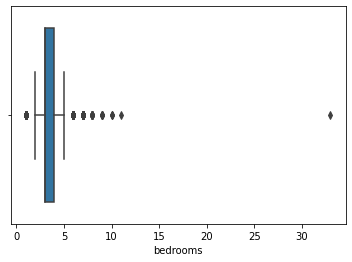

In [6737]:
sns.boxplot(re_df['bedrooms'])

In [6738]:
max(re_df['bedrooms'])

33

In [6739]:
#re_df = re_df[re_df.bedrooms != max(re_df['bedrooms'])]

re_df.loc[re_df['bedrooms'] == 33]

,date,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,price,area
15856,06/2014,33,1.75,1620,1.0,no,0,5,7,580,1947,47.6878,-122.331,1330,4700,640000,medium priced area


Based on the sqft_living we asume that there is typing error

In [6740]:
re_df.at[15856,'bedrooms'] = 3

#### bathrooms

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bathrooms'>

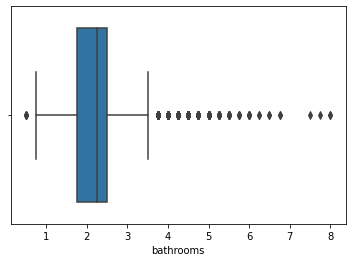

In [6741]:
sns.boxplot(re_df['bathrooms'])

In [6742]:
re_df['bathrooms'].value_counts()

#re_df = re_df[re_df.bathrooms != max(re_df['bathrooms'])]
#re_df = re_df[re_df.bathrooms != 7.75]

2.50    5376
1.00    3849
1.75    3048
2.25    2046
2.00    1929
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

#### sqft_lot

sns.boxplot(re_df['sqft_lot'])

max(re_df['sqft_lot'])

re_df.loc[re_df['sqft_lot'] == 1651359]

re_df.at[1717,'sqft_lot'] = 16513.59

#### price

In [6743]:
re_df = re_df[re_df['price'] < 4000000]

In [6744]:
#re_df.to_excel(r'cleaned_dataframe.xlsx', index = False)

## Plot the Correlation Heatmap

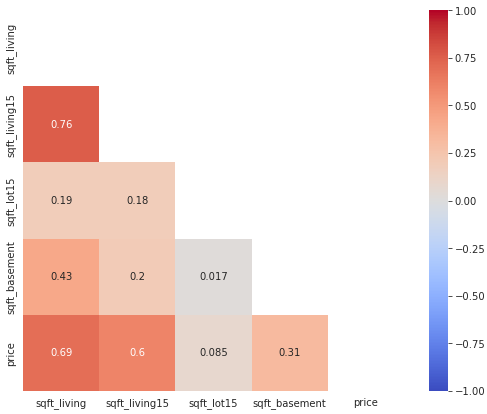

In [6745]:
re_num = re_df[['sqft_living','sqft_living15','sqft_lot15','sqft_basement','price']]

corr = re_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Split Data into groups

expensive_zipcodes= [98199, 98119, 98109, 98102, 98105, 98112, 98033, 98039, 98004, 98005, 98040, 98006, 98075]
expensive_areas = re_df[re_df['zipcode'].isin(expensive_zipcodes)]

affordable_areas = re_df[~re_df['zipcode'].isin(expensive_zipcodes)]

## X Y split

In [6746]:
X=re_df.drop("price", axis=1)
y=re_df["price"]

## Data Splitting

In [6747]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [6748]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Data Transformation

### Hot coding Categorical Variables

In [6749]:
X_train_cat=X_train[['date','bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','lat','long','area']]
X_train_cat

X_test_cat=X_test[['date','bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','lat','long','area']]
X_test_cat

,date,bedrooms,bathrooms,view,floors,waterfront,condition,grade,yr_built,lat,long,area
19459,07/2014,5,1.75,0,1.0,no,3,7,1966,47.7203,-122.229,medium priced area
7292,06/2014,3,1.00,0,1.5,no,3,7,1901,47.6865,-122.397,medium priced area
21143,04/2015,3,2.50,0,2.0,no,3,7,2008,47.5730,-122.372,affordable area
4224,11/2014,2,2.50,0,2.0,no,3,8,1994,47.6375,-122.387,expensive area
5067,07/2014,3,2.50,0,1.0,no,3,8,1953,47.5245,-122.384,medium priced area
...,...,...,...,...,...,...,...,...,...,...,...,...
1658,12/2014,8,5.00,0,2.0,no,3,8,1997,47.6086,-122.303,medium priced area
18441,09/2014,3,1.50,0,1.0,no,5,7,1957,47.2012,-122.000,affordable area
5714,09/2014,3,3.00,0,1.0,no,4,10,1979,47.3080,-122.087,affordable area
10233,06/2014,3,1.50,2,2.0,no,5,8,1913,47.6333,-122.347,expensive area


In [6750]:
X_train_cat=pd.get_dummies(X_train_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_train_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_train_cat).get_feature_names(input_features=X_train_cat.columns))

X_test_cat=pd.get_dummies(X_test_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_test_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_test_cat).get_feature_names(input_features=X_test_cat.columns))

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bathrooms_0.75,...,date_08/2014_1,date_09/2014_1,date_10/2014_1,date_11/2014_1,date_12/2014_1,waterfront_yes_1,area_expensive area_1,area_medium priced area_1,area_very expensive area_1,area_very_affordable area_1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6470,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6471,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6472,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [6751]:
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat = X_test_cat.reset_index(drop=True)

### Standardize numerical

In [6752]:
X_train_num=X_train[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_train_num

X_test_num=X_test[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_test_num

,sqft_living,sqft_living15,sqft_lot15,sqft_basement
19459,1360,1490,9935,300
7292,1210,1450,5264,0
21143,2040,1410,2500,570
4224,1590,1880,3675,290
5067,2060,1990,7560,900
...,...,...,...,...
1658,2800,1800,2580,920
18441,1550,1450,9282,0
5714,3760,2820,50543,1120
10233,2680,2280,5947,800


In [6753]:
std_scaler=StandardScaler().fit(X_train_num)   ## finding the parameters (mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train_num)

In [6754]:
X_test_scaled=std_scaler.transform(X_test_num)

In [6755]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

[[-0.37619609 -1.25475748 -0.39712138  0.20163432]
 [-0.6082163  -0.6404919   0.02846981  0.13365339]
 [-1.32637411 -0.90374858 -0.27290151 -0.65945752]
 ...
 [-0.3099046  -0.07010244 -0.19131204  1.17602773]
 [ 0.22042732 -0.09935319 -0.16047985 -0.65945752]
 [-0.53087623 -0.55566475 -0.30180891 -0.65945752]]
--------
[[-0.79604219 -0.72824413 -0.10095411  0.02035183]
 [-0.96177092 -0.78674561 -0.26744795 -0.65945752]
 [-0.04473864 -0.84524709 -0.36596839  0.63218025]
 ...
 [ 1.85561741  1.21693018  1.34648367  1.87849739]
 [ 0.66237059  0.42716016 -0.24310299  1.15336742]
 [ 0.36405888  1.61181519 -0.03084206  1.17602773]]


In [6756]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test_num.columns)

In [6757]:
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)

### Quantile Transformer

In [6758]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_living15'] = qt.transform(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_living15'] = qt.transform(X_test_scaled['sqft_living15'].to_numpy().reshape(-1,1))

In [6759]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_lot15'] = qt.transform(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_lot15'] = qt.transform(X_test_scaled['sqft_lot15'].to_numpy().reshape(-1,1))

pt = PowerTransformer().fit(y_train.to_numpy().reshape(-1,1))
y_train = pt.transform(y_train.to_numpy().reshape(-1,1))
y_test = pt.transform(y_test.to_numpy().reshape(-1,1))

## Concatination 

In [6760]:
X_train_con=pd.concat([X_train_scaled,X_train_cat],axis=1)
X_test_con=pd.concat([X_test_scaled,X_test_cat],axis=1)

In [6761]:
X_train_con

,sqft_living,sqft_living15,sqft_lot15,sqft_basement,bedrooms,bathrooms,view,floors,condition,grade,...,date_08/2014,date_09/2014,date_10/2014,date_11/2014,date_12/2014,waterfront_yes,area_expensive area,area_medium priced area,area_very expensive area,area_very_affordable area
0,-0.376196,-1.674186,-1.773922,0.201634,3,3.25,0,2.0,3,8,...,0,0,0,0,0,0,0,1,0,0
1,-0.608216,-0.530745,1.070745,0.133653,3,1.75,0,1.0,3,7,...,0,0,0,1,0,0,0,1,0,0
2,-1.326374,-0.959440,-0.660719,-0.659458,2,1.00,0,1.0,3,6,...,0,0,0,0,1,0,0,1,0,0
3,-0.652411,-0.840906,-0.101796,0.246955,3,1.50,0,1.0,3,7,...,0,0,0,0,1,0,0,1,0,0
4,-0.884431,-0.364191,-0.739737,-0.659458,3,1.00,0,1.0,3,6,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15101,1.192703,2.268169,0.939454,1.606574,3,2.50,3,1.0,3,11,...,0,1,0,0,0,0,1,0,0,0
15102,1.491014,1.460531,0.366928,-0.659458,4,2.50,0,2.0,3,10,...,0,0,1,0,0,0,0,1,0,0
15103,-0.309905,0.144780,-0.076604,1.176028,2,1.75,3,1.0,4,7,...,0,0,0,0,0,0,0,0,0,0
15104,0.220427,0.115678,0.232562,-0.659458,3,2.25,0,2.0,3,8,...,0,1,0,0,0,0,0,0,0,0


##  Apply Linear Regression

### Modelling using Statsmodels

In [6762]:
X_train_const_scaled = sm.add_constant(X_train_con) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_con) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     1917.
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:39:21   Log-Likelihood:            -2.0240e+05
No. Observations:               15106   AIC:                         4.049e+05
Df Residuals:                   15075   BIC:                         4.051e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [6763]:
predictions_test

0       3.747864e+05
1       4.973006e+05
2       3.814918e+05
3       6.296667e+05
4       5.784739e+05
            ...     
6469    6.023630e+05
6470    2.058115e+05
6471    7.587864e+05
6472    1.010634e+06
6473    6.072909e+05
Length: 6474, dtype: float64

In [6764]:
#display adjusted R-squared
print(model.rsquared_adj)

0.7918586081122586


### Modeling using Scikit Learn

In [6765]:
model=LinearRegression()    # model
model.fit(X_train_con, y_train)   # model train

LinearRegression()

In [6766]:
model.coef_

array([ 167211.57902569,  -10580.84433271,   -7311.46744295,
        -26887.44841726,  -25239.07748363,   29969.56108775,
         58901.91891938,  -17191.02178469,   22706.71420382,
         70248.71170477,   -1537.5345364 ,  328290.84965284,
       -106987.74629878,   -5845.32130408,   17222.48694917,
         26344.9810473 ,  -16967.82784175,   42963.26875677,
        -13832.21437934,   -9431.33669854,  -11782.94995255,
        -26710.84425357,  -14992.60770022,   -9214.58199205,
        -18060.5886196 ,  590947.70113146,  221898.38439902,
        114571.90550415,  555150.92895269,   -4924.01401691])

In [6767]:
model.intercept_

-25788380.308709115

Making prediction

In [6768]:
y_pred=model.predict(X_test_con)   # model prediction
##y_pred_train=model.predict(X_train_scaled)

In [6769]:
y_test

0        431200
1        285000
2        494900
3        509500
4        731100
         ...   
6469     490000
6470     245000
6471     555000
6472    1360000
6473     490000
Name: price, Length: 6474, dtype: int64

In [6770]:
y_pred

array([ 374786.44813998,  497300.62942229,  381491.8455171 , ...,
        758786.38958236, 1010633.54867516,  607290.85549878])

In [6771]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

,y_test,y_pred
0,431200,3.747864e+05
1,285000,4.973006e+05
2,494900,3.814918e+05
3,509500,6.296667e+05
4,731100,5.784739e+05
...,...,...
6469,490000,6.023630e+05
6470,245000,2.058115e+05
6471,555000,7.587864e+05
6472,1360000,1.010634e+06


Linear Regression Train-test split. Standardize the data (after the data split). Apply linear regression. Model Interpretation. Model Validation Model Evaluation: MSE. RMSE. MAE. R2. Adjusted R2. Feature Importance.

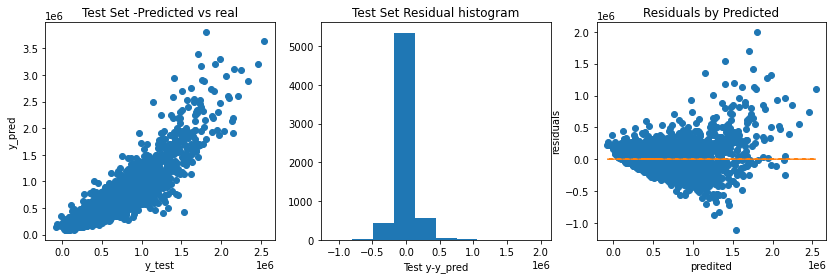

In [6772]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

#### Error metrics

In [6773]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

23255803734.540897
97194.0724326553


In [6774]:
R2=r2_score(y_test,y_pred)
R2

0.8029832608918765

In [6775]:
X_test.shape[1]

16

In [6776]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.8024950670207708

#### Feature Importance

In [6777]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_con.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance')

In [6778]:
features_importances

,Attribute,Importance
10,yr_built,1537.534536
29,area_very_affordable area,4924.014017
13,date_02/2015,5845.321304
2,sqft_lot15,7311.467443
23,date_11/2014,9214.581992
19,date_07/2014,9431.336699
1,sqft_living15,10580.844333
20,date_08/2014,11782.949953
18,date_06/2014,13832.214379
22,date_10/2014,14992.607700


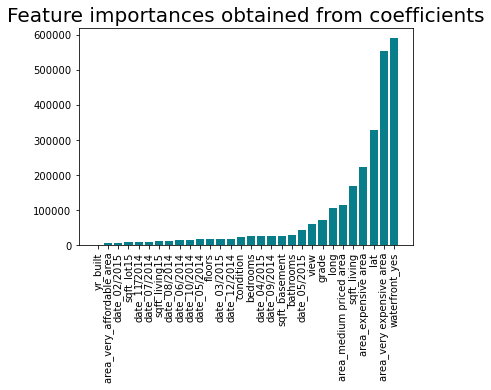

In [6779]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Evaluating predictions

In [6780]:
# MAE: mean absolute error
MAE = np.mean( np.abs( y_test - y_pred ) )
MAE

97194.07243265519

In [6781]:
# MSE: mean squared error
MSE = np.mean( np.power( y_test - y_pred , 2 ) )
MSE

23255803734.540928

In [6782]:
# RMSE: root mean squared error
RMSE = np.sqrt(MSE)
RMSE

152498.53682754116

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'price'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

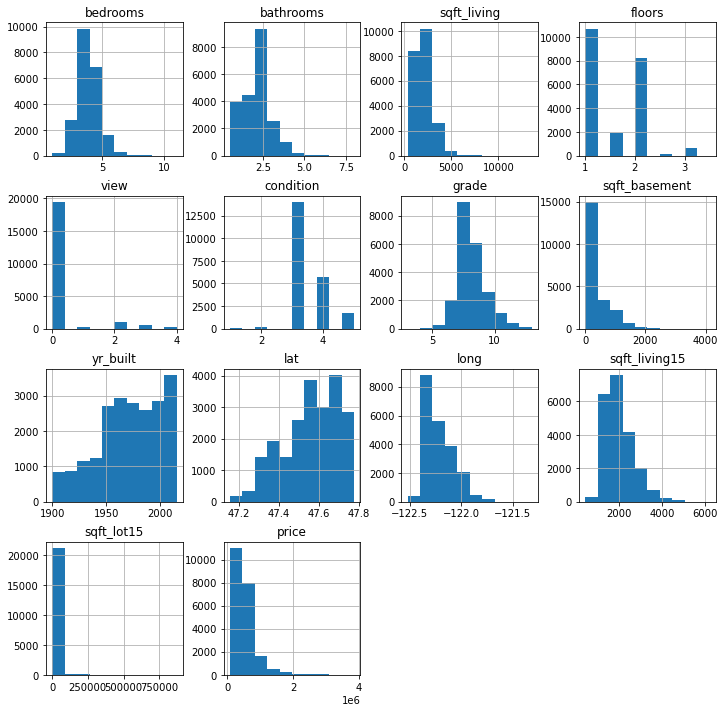

In [6783]:
re_df.hist(figsize=(12,12))